In [104]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS


In [105]:
bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})
#list(bol.columns)

In [106]:

#list(bol.columns)
offset = 1000  

# EGDP
sat = pd.read_csv("data/egdp/satelite_data.csv")
sat["EGDPpc2012"] = (sat["egdp2012"]*1000000/ bol["tr400_pop2012"])
sat["lnEGDPpc2012"] = np.log(sat["EGDPpc2012"])

# Merge
df = pd.merge(bol, sat, on="id", how="outer")

# Land cover
df["lnagr_land2012"] = np.log(df["agr_land2012"] + offset)
df["lnurb_land2012"] = np.log(df["urb_land2012"] + offset)

df["total_land2012"] = df["agr_land2012"] + df["urb_land2012"]
df["perUrb_land"] = df["urb_land2012"] / df["total_land2012"]
df["ln_perUrb_land"] = np.log(df["perUrb_land"].fillna(0) + offset)

# Population
df["ln_tr400_pop2012"] = np.log(df["tr400_pop2012"])

# PM2.5
df["ln_pm25_2012"] = np.log(df["pm25_2012"])

# Surface temperature
df["ln_land_temp2012"] = np.log(df["land_temp2012"])

# **Data exploration**

In [107]:
short_df = df[["imds","ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 
               'ln_land_temp2012', "lnagr_land2012", "lnurb_land2012", "ln_perUrb_land"]]
short_df.isna().sum()

imds                0
ln_t400NTLpc2012    0
ln_tr400_pop2012    0
lnEGDPpc2012        0
ln_pm25_2012        0
ln_land_temp2012    0
lnagr_land2012      0
lnurb_land2012      0
ln_perUrb_land      0
dtype: int64

In [108]:
print(df[["agr_land2012", "urb_land2012"]])

     agr_land2012  urb_land2012
0        0.000000      0.000000
1        0.000000      0.000000
2        0.000000      0.000000
3       50.276154    195.118281
4        0.000000      0.000000
..            ...           ...
334      0.000000      1.254882
335      8.085184      0.000000
336     29.080455      0.000000
337      0.000000    320.778602
338     47.023029     16.002446

[339 rows x 2 columns]


In [109]:
short_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   imds              339 non-null    float64
 1   ln_t400NTLpc2012  339 non-null    float64
 2   ln_tr400_pop2012  339 non-null    float64
 3   lnEGDPpc2012      339 non-null    float64
 4   ln_pm25_2012      339 non-null    float64
 5   ln_land_temp2012  339 non-null    float64
 6   lnagr_land2012    339 non-null    float64
 7   lnurb_land2012    339 non-null    float64
 8   ln_perUrb_land    339 non-null    float64
dtypes: float64(9)
memory usage: 24.0 KB


In [110]:
short_df.describe()

imds  ln_t400NTLpc2012  ln_tr400_pop2012  lnEGDPpc2012  \
count  339.000000        339.000000        339.000000    339.000000   
mean    51.050442         13.033028          9.335445      8.395351   
std      6.771824          1.671621          1.145385      1.238107   
min     35.700001          0.856095          6.251161      4.706205   
25%     47.000000         12.050438          8.686743      7.528378   
50%     50.500000         13.118243          9.294614      8.238783   
75%     54.850001         14.268402          9.903637      9.158287   
max     80.199997         17.071051         14.171911     11.689671   

       ln_pm25_2012  ln_land_temp2012  lnagr_land2012  lnurb_land2012  \
count    339.000000        339.000000      339.000000      339.000000   
mean       3.118672          5.696477        6.966940        7.004299   
std        0.287753          0.011639        0.179915        0.394750   
min        2.111170          5.659918        6.907755        6.907755   
25%        2.893310          5.689875        6.907755        6.907755   
50%        3.087198          5.698119        6.913097        6.907755   
75%        3.357998          5.705713        6.935352        6.928602   
max        3.649784          5.720777        8.374316       10.265991   

       ln_perUrb_land  
count      339.000000  
mean         6.908019  
std          0.000346  
min          6.907755  
25%          6.907755  
50%          6.907755  
75%          6.908288  
max          6.908755

In [111]:
mod = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 + lnEGDPpc2012 + ln_pm25_2012 ", 
              data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   imds   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     52.92
Date:                Sat, 22 Jun 2024   Prob (F-statistic):           1.65e-34
Time:                        15:36:02   Log-Likelihood:                -1045.7
No. Observations:                 339   AIC:                             2101.
Df Residuals:                     334   BIC:                             2121.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.8725      4.370  

In [112]:
missing_labels = df.columns[df.isna().any()]
missing_labels

Index(['sdg1_1_eepr', 'sdg2_4_pual', 'sdg2_4_td', 'sdg5_5_gpop', 'sdg8_4_rem',
       'sdg9_5_eutf', 'sdg10_2_iec', 'sdg1_1_dtl_abs', 'sdg2_4_apu_abs',
       'sdg2_4_tm_abs', 'sdg3_1_udhf_ab', 'sdg8_4_rem_abs', 'sdg9_5_eutf_abs',
       'ln_NTLpc2012', 'ln_NTLpc2013', 'ln_NTLpc2014', 'ln_NTLpc2015',
       'ln_NTLpc2016', 'ln_NTLpc2017', 'ln_NTLpc2018', 'ln_NTLpc2019',
       'ln_NTLpc2020', 'perUrb_land'],
      dtype='object')

In [113]:
#plt.style.available

[Text(0.5, 1.0, 'PM25')]

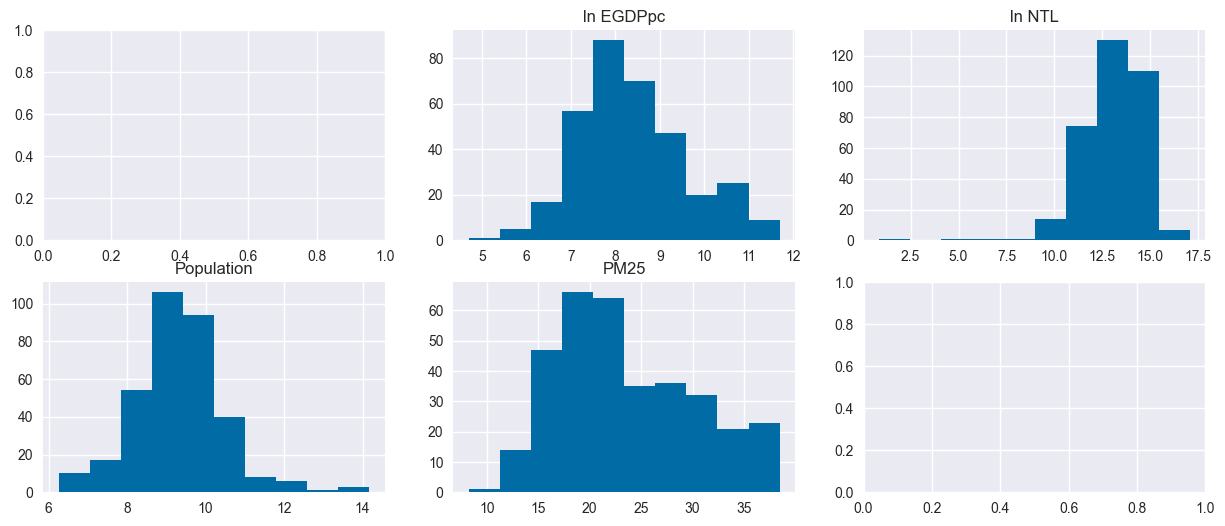

In [114]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
#ax0.hist(df["perUrb_land"])
#ax0.set(title="Percentage of Urban Land")

ax1.hist(df["lnEGDPpc2012"])
ax1.set(title="ln EGDPpc")

ax2.hist(df["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(df["ln_tr400_pop2012"])
ax3.set(title= "Population")

ax4.hist(df["pm25_2012"])
ax4.set(title= "PM25")

#ax5.hist(df["land_temp2012"])
#ax5.set(title= "Land Surface Temperature");


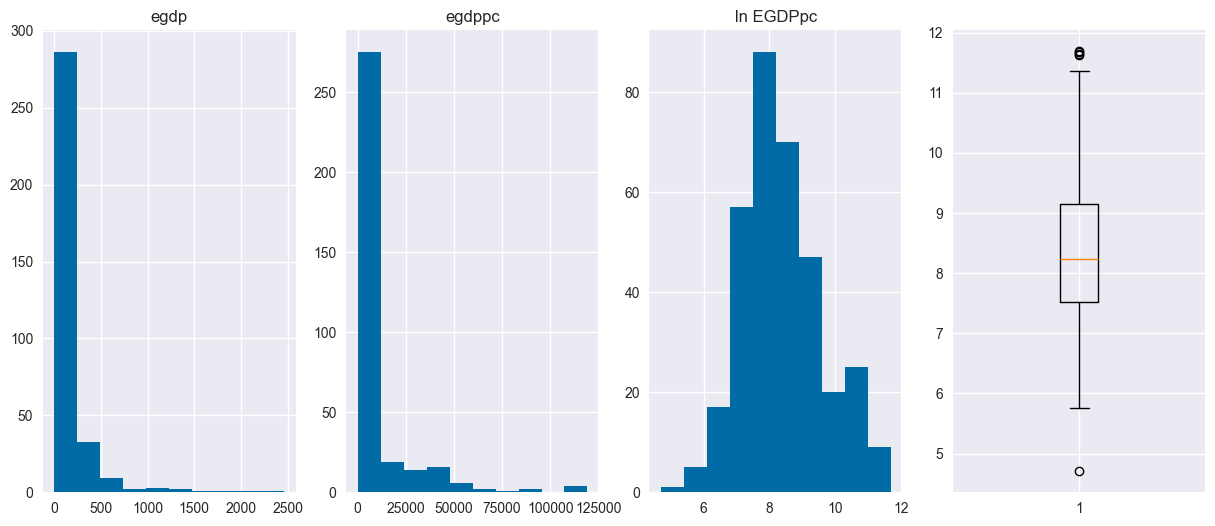

In [115]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=1,
                                 ncols=4,
                                 figsize=(15,6)
                                 )
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(df["EGDPpc2012"])
ax1.set(title= "egdppc")

ax2.hist(df["lnEGDPpc2012"])
ax2.set(title="ln EGDPpc")

ax4.boxplot(df["lnEGDPpc2012"]);


In [116]:
#plt.style.available

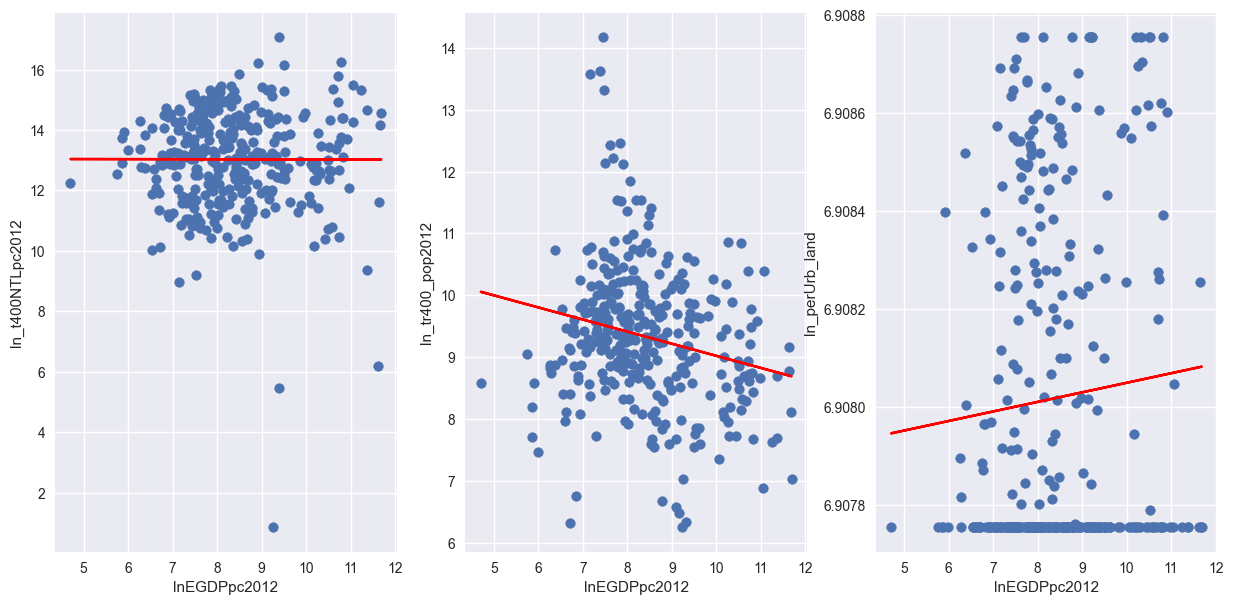

In [117]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")



In [118]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["lnEGDPpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["lnEGDPpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: -0.21141855279870278
Correlation of egdp and Urban land %: 0.06980531985494491


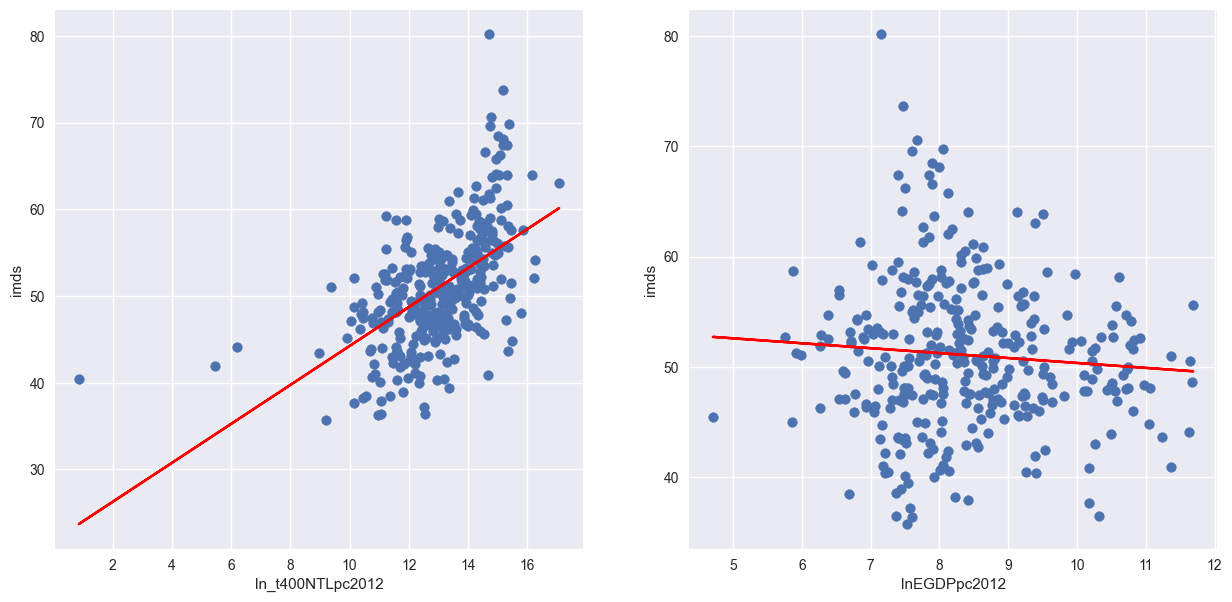

In [119]:

fig, (ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize=(15,7))

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"], p(short_df["lnEGDPpc2012"]), "r-")

In [120]:
ntl_imds = short_df["ln_t400NTLpc2012"].corr(short_df['imds'])
egdp_imds = short_df["lnEGDPpc2012"].corr(short_df['imds'])

print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

Correlation of ntl and imds: 0.5548280194761073
Correlation of egdp and imds: -0.08182429944254284


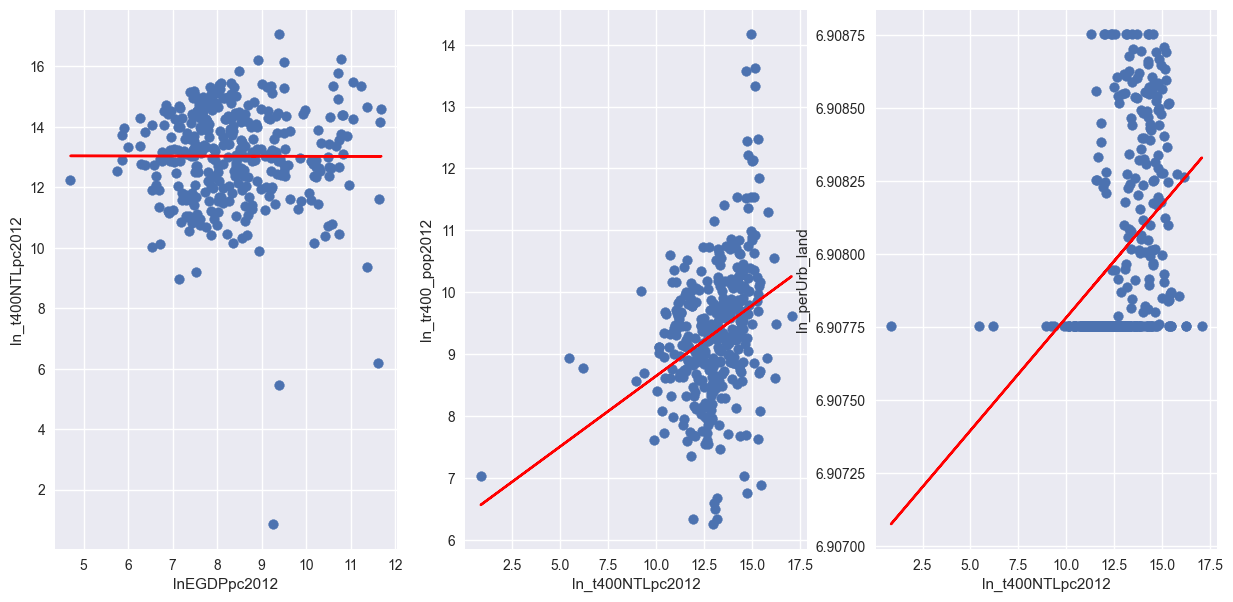

In [121]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="ln_t400NTLpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-")



In [122]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["ln_t400NTLpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["ln_t400NTLpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

Correlation of egdp and ntl: -0.0013160348349785576
Correlation of egdp and pop: 0.3324972344406324
Correlation of egdp and Urban land %: 0.3744299375753733


# **Regression models**

### Linear model

In [124]:
x = df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()
model.fit(x_train,y_train)

# r2 
#lr = model.score(x_test, y_test)
lr = np.mean(cross_val_score(model, x, y))

# MAE
lr_mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))

lr_y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


### Ridge  model

In [125]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()
rid_model.fit(x_train, y_train)

# r2
#ri = rid_model.score(x_test, y_test)
ri = np.mean(cross_val_score(rid_model, x, y))

ri_y_pred = rid_model.predict(x_test)

# MAE
ri_mae = np.mean(cross_val_score(rid_model, x, y, scoring="neg_mean_absolute_error"))

### Random Forest Regressor model

In [126]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

# r2
#rf = rf_model.score(x_test, y_test)
rf = np.mean(cross_val_score(rf_model, x, y))

rf_y_pred = rf_model.predict(x_test)

# MAE
rf_mae = np.mean(cross_val_score(rf_model, x, y, scoring="neg_mean_absolute_error"))

### Results 

In [129]:
print("R2 for the regressor models")
print(f" Linear model  cv ->   R2: {lr*100:.2f}%,  MAE: {lr_mae:.2f}")
print(f" Ridger model  cv ->   R2: {ri*100:.2f}%,  MAE: {ri_mae:.2f}")
print(f" RF model      cv ->   R2: {rf*100:.2f}%,  MAE: {rf_mae:.2f} ")

R2 for the regressor models
 Linear model  cv ->   R2: 31.38%,  MAE: -4.34
 Ridger model  cv ->   R2: 30.71%,  MAE: -4.35
 RF model      cv ->   R2: 46.68%,  MAE: -3.78 


### Correlation between prediction and truth data

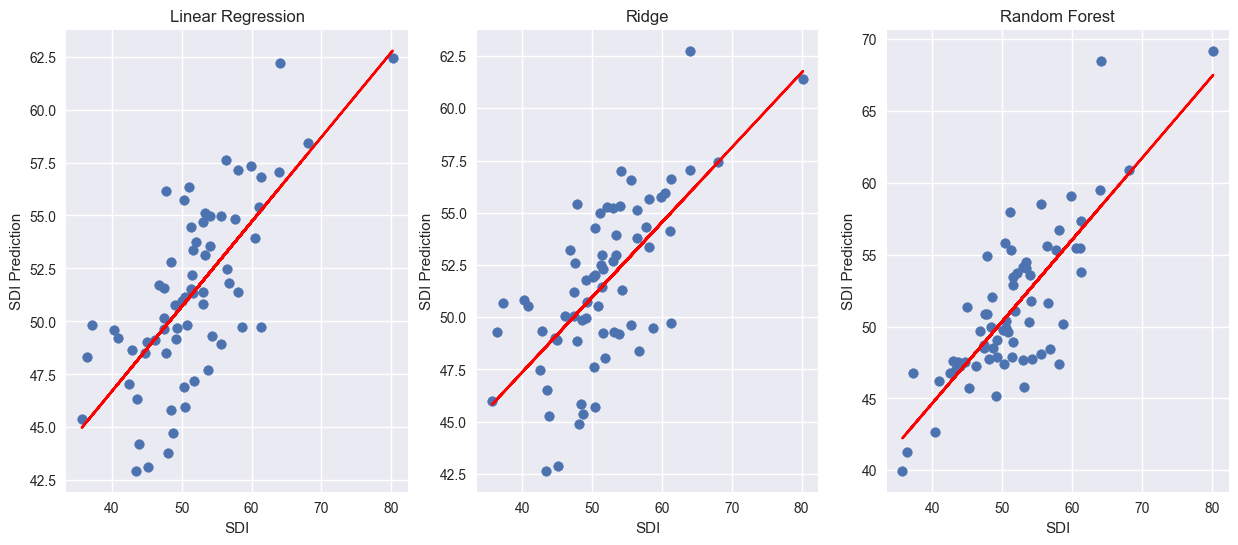

In [132]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize = (15, 6))

ax0.scatter(x = y_test, y = lr_y_pred)
ax0.set(xlabel="SDI", ylabel="SDI Prediction", title="Linear Regression")

# add trendline
z = np.polyfit(y_test, lr_y_pred, 1)
p = np.poly1d(z)
ax0.plot(y_test,p(y_test),"r-")


ax1.scatter(x=y_test, y = ri_y_pred)
ax1.set(xlabel="SDI", ylabel="SDI Prediction", title="Ridge")

# add trendline
z = np.polyfit(y_test, ri_y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test,p(y_test),"r-")


ax2.scatter(x=y_test, y=rf_y_pred)
ax2.set(xlabel="SDI", ylabel="SDI Prediction", title="Random Forest")


# add trendline
z = np.polyfit(y_test, rf_y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test,p(y_test),"r-")


# **Categorical analysis**

In [24]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']
df["imds_quantile"] = pd.qcut(df["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [25]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'lnagr_land2012', 'lnurb_land2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

 Test data score: 50.00%


In [26]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

        high       0.80      0.67      0.73        18
         low       0.43      0.60      0.50        15
 medium-high       0.38      0.28      0.32        18
  medium-low       0.42      0.47      0.44        17

    accuracy                           0.50        68
   macro avg       0.51      0.50      0.50        68
weighted avg       0.51      0.50      0.50        68



In [27]:
print(confusion_matrix(y_test, y_preds))

[[12  2  4  0]
 [ 0  9  1  5]
 [ 2  5  5  6]
 [ 1  5  3  8]]


In [28]:
accuracy_score(y_test, y_preds)

0.5

In [29]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

Trying model with 10 stimators
Model acurracy is 47.06%
Trying model with 20 stimators
Model acurracy is 48.53%
Trying model with 30 stimators
Model acurracy is 44.12%
Trying model with 40 stimators
Model acurracy is 51.47%
Trying model with 50 stimators
Model acurracy is 48.53%
Trying model with 60 stimators
Model acurracy is 42.65%
Trying model with 70 stimators
Model acurracy is 42.65%
Trying model with 80 stimators
Model acurracy is 45.59%
Trying model with 90 stimators
Model acurracy is 47.06%


In [30]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [31]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [32]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [33]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

R2 for the classifier models
 Random Forest model: 50.00%
 Linear SVC model: 44.12%
 Naive Bayes model: 39.71%


## Iterate regression models

In [34]:
y_variables = list(bol.columns)
del y_variables[195:420]
del y_variables[10:13]
del y_variables[0:8]

In [35]:
#y_variables

### Linear Regression

In [36]:
model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()
    model.fit(x_train,y_train)

    y_pred = model.predict(x_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))


    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]


In [37]:
model_results[model_results["r2"]>0.9]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [38]:
model_results[model_results["r2"]>0.8]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [39]:
model_results[model_results["r2"]>0.7]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [40]:
model_results[model_results["r2"]>0.6]

Feature        r2          MAE
64  sdg1_1_pubn_abs  0.698342 -3561.573073

In [133]:
#model_results[model_results["r2"]<0]

### Random Forest Regressor

In [42]:
model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])

In [43]:

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    y = filtered_df[y_variable]

    np.random.seed(42)
    #x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = RandomForestRegressor()
    #model.fit(x_train,y_train)

    #y_pred = model.predict(x_test)
    #mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    
    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]

#res_90 = {key: value for key, value in model_results.items() if value > 0.9}
#res_80 = {key: value for key, value in model_results.items() if (value > 0.8 and value < 0.9)}
#res_70 = {key: value for key, value in model_results.items() if (value > 0.7 and value < 0.8)}

#res_neg = {key: value for key, value in model_results.items() if value < 0}

#    print(f"For the variable {y_variable} Mean Squared Error:", mse)
#    print("R^2 Score:", r2)

In [44]:
model_results[model_results["r2"]>0.9]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [45]:
model_results[model_results["r2"]>0.8]

Feature        r2          MAE
64  sdg1_1_pubn_abs  0.806113 -2669.752581
93  sdg8_5_ompr_abs  0.842334  -462.245281
94  sdg8_5_ofpr_abs  0.807598  -828.260705
96   sdg8_6_wlm_abs  0.816453  -113.976013

In [46]:
model_results[(model_results["r2"]>=0.7) & (model_results["r2"]<0.8)]

Feature        r2          MAE
63   sdg1_1_dtl_abs  0.700273 -1050.538142
72    sdg3_2_fb_abs  0.707632    -4.146106
79   sdg3_7_bpw_abs  0.731094   -21.670247
104  sdg11_1_ho_abs  0.760973  -375.197139

In [47]:
model_results[(model_results["r2"]>=0.6) & (model_results["r2"]<0.7)]

Feature        r2           MAE
66    sdg1_4_ebs_abs  0.626654 -1.001922e+03
68    sdg2_2_wow_abs  0.665525 -3.801598e+02
73    sdg3_2_ffb_abs  0.676694 -5.621895e+00
82    sdg4_4_heu_abs  0.632329 -7.019964e+02
85    sdg4_c_uts_abs  0.615433 -1.994770e+01
95    sdg8_6_mlm_abs  0.666318 -8.475488e+01
101    sdg9_c_hf_abs  0.674296 -8.144846e+02
105  sdg11_1_wos_abs  0.683982 -8.054588e+02
112  sdg16_6_aob_abs  0.615646 -1.566184e+07

In [48]:
model_results[model_results["r2"]<0]

Feature           r2            MAE
7           sdg2_4_pual    -1.053063     -77.741269
8             sdg2_4_td    -0.206102     -54.999176
12          sdg3_3_cdir    -0.989357      -2.191097
13            sdg3_3_di  -436.450899      -2.210021
14           sdg3_3_imr   -47.806323      -0.824969
16          sdg3_3_hivi    -0.153333     -53.545127
18         sdg4_1_ssdrm    -0.012677      -1.611786
22           sdg4_c_qti    -0.021323     -25.212885
23           sdg4_c_qts    -0.364393     -12.845835
24          sdg5_1_gpsd    -0.272390      -0.575334
30           sdg6_3_wwt    -0.080496     -10.838767
34        sdg7_3_co2epc    -0.376231      -0.540741
36          sdg8_5_oprm    -0.023050      -3.797313
38           sdg8_6_mlm    -0.145519      -3.502592
43            sdg9_5_cd    -3.180811      -3.017108
52         sdg11_2_samt    -0.994576     -69.163748
55          sdg13_2_dra    -0.599623      -0.707131
57          sdg15_5_blr    -0.170967      -0.202065
58          sdg16_1_rhr    -0.198205      -1.282739
59         sdg16_6_pbec    -0.025436      -8.349852
60           sdg16_9_cr    -0.032446      -3.585006
62         sdg17_5_pipc    -0.089338    -347.137816
69       sdg2_4_apu_abs    -0.544708  -97324.565719
70        sdg2_4_tm_abs    -0.382787    -129.918050
74        sdg3_3_cd_abs   -31.103481    -190.847952
75        sdg3_3_pd_abs -1988.808528     -13.458925
76        sdg3_3_mc_abs  -746.960698    -199.941739
86       sdg6_1_wdc_abs    -0.119083   -2771.543834
87       sdg6_2_bsc_abs    -0.027837   -4890.167708
99       sdg9_5_kcd_abs    -1.142640    -292.294648
106     sdg11_2_mtv_abs    -0.822699   -2256.985834
107    sdg13_2_tco2_abs    -0.343825 -550139.777437
108      sdg13_2_ad_abs    -0.180704   -1687.083074
109      sdg15_1_pa_abs    -0.051868   -1114.798922
110      sdg15_5_rl_abs    -0.161418      -0.599526
122      sdg2_4_td_norm    -0.139213      -7.987387
126    sdg3_3_cdir_norm    -0.541682     -14.412961
127      sdg3_3_di_norm    -2.750614      -9.007457
128     sdg3_3_imr_norm   -39.919782      -2.698582
130    sdg3_3_hivi_norm    -0.090350     -11.928907
136     sdg4_c_qti_norm    -0.027327     -25.187549
137     sdg4_c_qts_norm    -0.364071     -12.806646
138    sdg5_1_gpsd_norm    -0.327011      -7.164706
144     sdg6_3_wwt_norm    -0.028953      -9.954786
148  sdg7_3_co2epc_norm    -0.026455      -6.152565
150    sdg8_5_oprm_norm    -0.017068     -17.224641
152     sdg8_6_mlm_norm    -0.160781     -10.450833
154    sdg8_10_dbb_norm    -0.001984     -14.590264
166   sdg11_2_samt_norm    -0.279917      -6.666377
169    sdg13_2_dra_norm    -0.276948      -9.236465
170     sdg15_1_pa_norm    -0.057563     -25.265423
171    sdg15_5_blr_norm    -0.023359     -15.990475
172    sdg16_1_rhr_norm    -0.094245     -14.647183
173   sdg16_6_pbec_norm    -0.058014     -12.732290
174     sdg16_9_cr_norm    -0.015592      -7.190353
176   sdg17_5_pipc_norm    -0.095658     -10.092922
180          index_sdg4    -0.059022      -8.596744

## Ridge model

In [49]:
ridge_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])

In [50]:
for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    y = filtered_df[y_variable]

    np.random.seed(42)
    #x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    ridge_model = linear_model.Ridge()
    #model.fit(x_train,y_train)

    r2 = np.mean(cross_val_score(ridge_model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(ridge_model, x, y, scoring="neg_mean_absolute_error"))
    
    ridge_results.loc[len(ridge_results.index)] = [y_variable, r2, mae]

In [51]:
ridge_results[ridge_results["r2"]>0.9]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [52]:
ridge_results[ridge_results["r2"]>0.8]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [53]:
ridge_results[(ridge_results["r2"]>=0.7) & (ridge_results["r2"]<0.8)]

Feature        r2          MAE
64  sdg1_1_pubn_abs  0.705611 -3485.614561

In [54]:
ridge_results[(ridge_results["r2"]>=0.6) & (ridge_results["r2"]<0.7)]

Empty DataFrame
Columns: [Feature, r2, MAE]
Index: []

In [58]:
ridge_results[(ridge_results["r2"]<0.6)& (ridge_results["r2"]>0)]

Feature        r2        MAE
0          imds  0.291257  -3.878303
1     rank_imds  0.312747 -63.045837
2    sdg1_1_ubn  0.198765 -10.922066
3    sdg1_2_mpi  0.390562  -0.055705
4    sdg1_4_abs  0.101311 -14.463981
..          ...       ...        ...
179  index_sdg3  0.130245  -5.211146
180  index_sdg4  0.007928  -8.173326
181  index_sdg5  0.000796  -6.405013
182  index_sdg6  0.120793 -10.587203
183  index_sdg7  0.465445  -8.051217

[135 rows x 3 columns]

In [55]:
ridge_results[ridge_results["r2"]<0]

Feature          r2           MAE
7          sdg2_4_pual  -11.236117 -1.033719e+02
8            sdg2_4_td   -1.296031 -7.116293e+01
12         sdg3_3_cdir   -0.195868 -1.869195e+00
13           sdg3_3_di  -33.739092 -2.342546e+00
14          sdg3_3_imr  -11.998357 -8.363244e-01
16         sdg3_3_hivi   -0.020782 -5.177401e+01
22          sdg4_c_qti   -0.018079 -2.574941e+01
23          sdg4_c_qts   -0.313970 -1.228447e+01
24         sdg5_1_gpsd   -0.040125 -5.614587e-01
34       sdg7_3_co2epc   -0.050719 -5.438686e-01
36         sdg8_5_oprm   -0.016211 -3.848134e+00
43           sdg9_5_cd   -0.937897 -2.994441e+00
54       sdg13_2_tco2e   -0.695394 -2.227015e+01
55         sdg13_2_dra   -4.072255 -9.124754e-01
56          sdg15_1_pa   -0.021195 -1.652621e+01
57         sdg15_5_blr   -0.014412 -1.906346e-01
58         sdg16_1_rhr   -0.010443 -1.269143e+00
62        sdg17_5_pipc   -0.000170 -3.266571e+02
69      sdg2_4_apu_abs   -4.779680 -1.209420e+05
70       sdg2_4_tm_abs   -1.734927 -1.923096e+02
74       sdg3_3_cd_abs   -1.866775 -1.728649e+02
75       sdg3_3_pd_abs -144.803379 -1.361503e+01
76       sdg3_3_mc_abs -143.471922 -2.018491e+02
78      sdg3_3_vih_abs   -0.534072 -8.664531e+00
82      sdg4_4_heu_abs   -0.421635 -1.412535e+03
84      sdg4_c_uti_abs   -0.582935 -6.636555e+00
89      sdg7_1_rec_abs   -0.261508 -3.458844e+06
91      sdg7_3_tee_abs   -0.303709 -2.642516e+04
99      sdg9_5_kcd_abs   -2.629658 -4.899772e+02
102      sdg9_c_tr_abs   -0.226450 -6.626970e+01
106    sdg11_2_mtv_abs   -1.779764 -4.021470e+03
107   sdg13_2_tco2_abs   -1.287946 -5.349929e+05
108     sdg13_2_ad_abs   -3.071302 -2.006976e+03
109     sdg15_1_pa_abs   -0.338268 -1.748837e+03
110     sdg15_5_rl_abs   -0.610156 -6.256505e-01
111     sdg16_1_rh_abs   -0.079999 -1.604421e+00
114    sdg17_5_tpi_abs   -0.060607 -1.149567e+07
122     sdg2_4_td_norm   -1.243511 -1.041451e+01
126   sdg3_3_cdir_norm   -0.171749 -1.373488e+01
127     sdg3_3_di_norm   -0.935053 -9.527256e+00
128    sdg3_3_imr_norm   -8.929278 -2.735336e+00
130   sdg3_3_hivi_norm   -0.005200 -1.160440e+01
136    sdg4_c_qti_norm   -0.018070 -2.574576e+01
137    sdg4_c_qts_norm   -0.314036 -1.228451e+01
138   sdg5_1_gpsd_norm   -0.825857 -8.120106e+00
150   sdg8_5_oprm_norm   -0.013826 -1.741480e+01
169   sdg13_2_dra_norm   -2.436546 -1.305729e+01
176  sdg17_5_pipc_norm   -0.000090 -9.529323e+00

# Adjust Hyperparameters

In [60]:
ridge_model.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

In [74]:
def evaluate_preds(model, y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    metric_dict = {"R2": round(r2, 2),
                   "MAE": round(mae, 2)}
    print(f"R2: {r2 * 100:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return metric_dict

In [101]:
alpha= range(35,1000,20)
grid = {"alpha": alpha,
        "copy_X": [True, False],
        "max_iter": [None, 10, 100, 200, 500, 1000, 10000], 
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]}

np.random.seed(42)

x = df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
y = df['imds']

rs_rid_model= RandomizedSearchCV(estimator = rid_model,
                       param_distributions=grid,
                       n_iter=100,
                       cv=5,
                       verbose=0)

rs_rid_model.fit(x_train, y_train);

In [102]:
rs_rid_model.best_params_

{'solver': 'cholesky', 'max_iter': 200, 'copy_X': False, 'alpha': 75}

In [103]:
# Uses the best model for the prediction
rs_y_preds = rs_rid_model.predict(x_test)

rs_metrics = evaluate_preds(rs_rid_model, x, y)

R2: 31.88%
MAE: -4.31
